# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [186]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [187]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [188]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,Not Verified | Food was lousy. Who ever is pl...
1,✅ Trip Verified | Had the worst experience. Th...
2,✅ Trip Verified | The ground staff were not h...
3,✅ Trip Verified | Second time BA Premium Econ...
4,Not Verified | They changed our Flights from ...


In [189]:
df.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [190]:
df['reviews'] = df['reviews'].str.split('|' , expand=True)[1]

In [191]:
df.head()

,reviews
0,Food was lousy. Who ever is planning the Asi...
1,Had the worst experience. The flight from Lon...
2,The ground staff were not helpful. Felt like...
3,Second time BA Premium Economy in a newer ai...
4,They changed our Flights from Brussels to Lo...


# VADER method #
We'll use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos score 
* removing stop words

In [192]:
example = df["reviews"][0]
print(example)

  Food was lousy. Who ever is planning the Asian Hindu Vegetarian meal is clueless as to what this meal includes. The snack was also lousy. It took us 2 hours just to go from T5 to T3 and clear security check. The place was chaotic. We get to our boarding gate and again a long line with 40 minutes wait for someone to check passport and boarding pass. Seats in Premium economy was ok, but when the passenger in front reclines, there is very little space for the window seat passenger to cross over. Overall not a good airline.


In [193]:
from nltk.stem import WordNetLemmatizer


def preprocess_text(text):
    # tokenize text
    tokens = word_tokenize(text.lower())
    # remove stopwords
    filtered_tokens = [
        token for token in tokens if token not in stopwords.words("english")
    ]
    # lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # join tokens
    processed_text = " ".join(lemmatized_tokens)
    return processed_text


In [194]:
df['reviews'] = df['reviews'].apply(preprocess_text)

In [195]:
df.head(15)

,reviews
0,food lousy . ever planning asian hindu vegetar...
1,worst experience . flight london toronto got d...
2,ground staff helpful . felt like wanted rush u...
3,second time ba premium economy newer aircraft ...
4,changed flight brussels london heathrow lax 4/...
5,copenhagen chaotic ticket counter assignment h...
6,worst experience life trying deal customer ser...
7,due code sharing cathay pacific downgraded ba ...
8,lhr check quick first wing quickly security . ...
9,would n't recommend british airway . tried cal...


In [196]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [197]:
sia.polarity_scores(example)

{'neg': 0.11, 'neu': 0.842, 'pos': 0.049, 'compound': -0.7476}

In [198]:
df.reset_index(inplace=True)
df.head()

,index,reviews
0,0,food lousy . ever planning asian hindu vegetar...
1,1,worst experience . flight london toronto got d...
2,2,ground staff helpful . felt like wanted rush u...
3,3,second time ba premium economy newer aircraft ...
4,4,changed flight brussels london heathrow lax 4/...


In [199]:
# df.drop(columns=["level_0"], inplace=True)
df.rename(columns={"index": "review_id"}, inplace=True)

In [200]:
# run the polarity score on all reviews
res = {}
for i, row in df.iterrows():
    text = row["reviews"]
    myid = row["review_id"]
    res[myid] = sia.polarity_scores(text)
    

In [201]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index": "review_id"})
vaders = vaders.merge(df, how='left' )
vaders

,review_id,neg,neu,pos,compound,reviews
0,0,0.187,0.664,0.149,-0.5574,food lousy . ever planning asian hindu vegetar...
1,1,0.192,0.720,0.088,-0.6908,worst experience . flight london toronto got d...
2,2,0.113,0.680,0.207,0.5719,ground staff helpful . felt like wanted rush u...
3,3,0.074,0.552,0.374,0.9693,second time ba premium economy newer aircraft ...
4,4,0.170,0.762,0.069,-0.7889,changed flight brussels london heathrow lax 4/...
...,...,...,...,...,...,...
995,995,0.111,0.597,0.293,0.9701,delhi london . read many negative review briti...
996,996,0.098,0.680,0.222,0.9681,travel british airway like lucky able british ...
997,997,0.000,0.603,0.397,0.9569,british airway get plenty well deserved kickin...
998,998,0.087,0.673,0.240,0.9527,ba first class even . starting lounge t3 ; may...


In [204]:
# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'

In [205]:
# apply the function
vaders['Analysis'] = vaders['compound'].apply(vader_analysis)

In [206]:
vaders.head()

,review_id,neg,neu,pos,compound,reviews,Analysis
0,0,0.187,0.664,0.149,-0.5574,food lousy . ever planning asian hindu vegetar...,Negative
1,1,0.192,0.720,0.088,-0.6908,worst experience . flight london toronto got d...,Negative
2,2,0.113,0.680,0.207,0.5719,ground staff helpful . felt like wanted rush u...,Positive
3,3,0.074,0.552,0.374,0.9693,second time ba premium economy newer aircraft ...,Positive
4,4,0.170,0.762,0.069,-0.7889,changed flight brussels london heathrow lax 4/...,Negative


In [208]:
vader_counts = vaders['Analysis'].value_counts()
vader_counts

Positive    510
Negative    385
Neutral     105
Name: Analysis, dtype: int64

### Visual representation ###

([<matplotlib.patches.Wedge at 0x243050c4450>,
 [Text(-0.034551802045584716, 1.0994572174374968, 'Positive'),
  Text(-0.3234444522546508, -1.0513722872064344, 'Negative'),
  Text(1.2772151775079268, -0.43728868078581135, 'Neutral')],
 [Text(-0.018846437479409842, 0.5997039367840891, '51.0%'),
  Text(-0.17642424668435494, -0.5734757930216914, '38.5%'),
  Text(0.8041725191716577, -0.2753299101243997, '10.5%')])

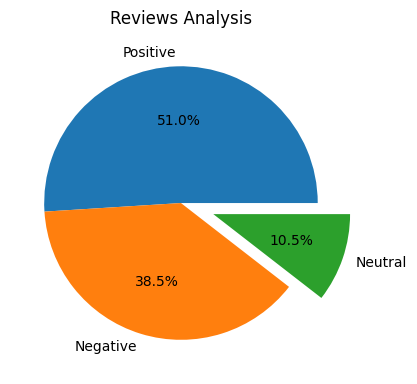

In [209]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,7))

plt.subplot(1,3,2)
plt.title("Reviews Analysis")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)